# A2 Inspecting synthetic galaxy catalogs

The purpose of this notebook is to run create a large sample of synthetic cluster members.  Later on these synthetic cluster members will be used to populate synthetic galaxy clusters


## Objectives


TBA


## Setup

This notebook relies on two prerequisites:

    * Data files from the previous calculation step. That is the output of the rejection sampling
    * synthetic software package. The host package of this tutorial


## Output

The outuput of this claculation is a very large set of synthetic galaxies sampled from the
    
    * galaxy clusters member model
    * reference line of sight model
    
## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [1]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle

import multiprocessing as mp

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader

# Preparation

## Setting up the file structure

The data files for this example calculation are pre packaged, and should be downloaded from a link provided upon request.

    1 dc2-alpha_concentric_sample-v01_test-03.tar.gz
    2 dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5
    3 dc2_cluster_sim_cutouts/clust_dc2-sim-LOS_v1.h5
    
These should be downloaded and placed in a file structure such that

    /root/
    |----/resamples/ 
    |----/dc2-alpha_concentric_sample-v01_test-03.tar.gz
    |----/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5
    |----/dc2_cluster_sim_cutouts/clust_dc2-sim-LOS_v1.h5
    
from within the root folder, extract the .tar.gz file using the command

    tar xzf dc2-alpha_concentric_sample-v01_test-03.tar.gz -C  resamples --strip-components 1    
    
This should yield a file structure as below
 
     /root/
    |----/resamples/ 
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run0_1846435878_rbin0.p
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run0_1846435878_rbin0_samples.fits
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run0_1846435878_rbin0_scores.fits
            .
            .
            .
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run3_664487101_rbin3.p
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run3_664487101_rbin3_samples.fits
    |--------------/dc2-alpha_concentric_sample-v01_test-03_run3_664487101_rbin3_scores.fits            
    |----/dc2-alpha_concentric_sample-v01_test-03.tar.gz
    |----/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5
    |----/dc2_cluster_sim_cutouts/clust_dc2-sim-LOS_v1.h5

In [2]:
# CHANGE THE ROOT PATH TO YOUR OWN PATH
root_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/"
deep_data_path = root_path + "dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5"
wide_data_path = root_path + "dc2_cluster_sim_cutouts/clust_dc2-sim-LOS_v1.h5"

## Configuration 

There are two primary inputs for this calculation: A low dimensional anchor distribution, and a high dimensional augmentation distribution. The distributions are estimated from datasets via KDE, and the dimensionality refers to the number of columns (features) in each dataset.

Both datasets are extracted from a catalog through a series of pre-processing steps. These steps are:

    (1) a shorthand name for each feature e.g. MAG_I, which can replace a more complicated name often encountered in astronomical databases e.g. mag_auto_deblend_mcal_v2_iband. This gives the user the task to identify columns in different catalogs as conceptually the same quantity, such as calibrated i-band magnitudes in different observations of the same *kind* of objects should be the same quantity, even if the catalog columns have different names
    
    (2) an instruction for transforming the catalog column. E.g. colors are defined as g - r color is specified as ("mag_g", "mag_r", "-"). A constant transformation is also allowed, e.g. z+1 is specified as ("z", 1, "+")
    
    (3) logarithmic scaling for each column, which is applied after the previous transformation. The boolean list for this should be specified in the same order as the column names in the first step
    
    (4) limits for clipping each column to a range. The list of tuples of limits for this should be specified in the same order as the column names in the first step.


Since the current example is defined for a simulated sky survey, both distributions are derived from the same galaxy catalog, so their selection in this notebook are identical. **NOTE This is only true for this notebook, in order to compare predictions to the ground truth**

In [3]:
deep_smc_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
        ("HALO_MASS", "halo_mass")        
    ],
    "logs": [False, True, False, False, False, False, True, True],
    "limits": [(0., 1.), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13), (10**9, 10**16)],
}

In [4]:
wide_cr_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
        ("HALO_MASS", "halo_mass"),
        ("LOGR", "R"),        
    ],
    "logs": [False, True, False, False, False, False, True, True, True],
    "limits": [(0., 1.), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13), (10**9, 10**16), (1e-3, 16)],
}


Only a few columns are actually used to connect the anchor and augmentation distributions

# Loading data from disk

## Loading the regular data tables

First load the two primary obsered datasets, since this is a simulated scenarion both are comprehensive and contain all relevant quantities 

In [5]:
refpixel = pd.read_hdf(deep_data_path, key="data")
table = pd.read_hdf(wide_data_path, key="data")

Then extract the desired columns and features

In [6]:
# loading random point reference data, in this case this is identical to the agumentation data
tmp_wide_cr_settings = wide_cr_settings.copy()
_wide_cr_settings_rands = emulator.construct_deep_container(refpixel, tmp_wide_cr_settings)

# loading augmentation catalogs, in this case this is a randomly chosen helpix pixel in the simulation
_deep_smc_settings = emulator.construct_deep_container(refpixel, deep_smc_settings)

# loading anchor data, in this case this is the cluster in the simulation
tmp_wide_cr_settings = wide_cr_settings.copy()
_wide_cr_settings_clust = emulator.construct_deep_container(table, tmp_wide_cr_settings)


(1513572, 9)
(1513572,)
(1513572, 8)
(1513572,)
(1009658, 9)
(1009658,)


## Loading the results of rejection sampling

Reading from file the results of the rejection sampling

These consist of the random samples which were evaluated, and of the P(x) values, that is the scores corresponding to those sampled data points.

Due numerical optimization, these files are saved separately. The different files are read separately, and then concatenated into a large data frame for each nested radial shell.

In [7]:
samples = []
scores = []
for rbin in np.arange(4):
    print(rbin)
    expr = root_path + "resamples/dc2-alpha_concentric_sample-v01_test-03/dc2-alpha_concentric_sample-v01_test-03_run0*_rbin" + str(rbin) + "*samples.fits" 

    fnames_samples = np.sort(glob.glob(expr))
    fnames_scores = []
    for fname in fnames_samples:
        fnames_scores.append(fname.replace("samples.fits", "scores.fits"))

    samples_sep = []
    scores_sep = []
    for i, fname in enumerate(fnames_samples):
#         print(fname)
        samples_sep.append(fio.read(fname))
        scores_sep.append(fio.read(fnames_scores[i]))
        
    samples.append(np.hstack(samples_sep))
    scores.append(np.hstack(scores_sep))

0
1
2
3


In [8]:
mag_lims = (17, 22.5)
r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]
redges = [-1.5, -0.5, 0., 0.5, 1.0]
rareas = np.array([np.pi*((10**redges[i+1])**2. - (10**redges[i])**2.) for i in np.arange(len(redges)-1)])

In [9]:
magcol = "mag_i"
ii = ((table[magcol] > mag_lims[0]) & (table[magcol] < mag_lims[1]))

clust_los_nums = np.histogram(np.log10(table[ii]["R"]), bins=redges)[0] / 41 # / nc

ii = ((refpixel[magcol] > mag_lims[0]) & (refpixel[magcol] < mag_lims[1]))
surfdens = len(refpixel[ii]) / hp.nside2pixarea(32, degrees=True) / 3600 / 3
rands_los_nums = surfdens * rareas
# rands_los_nums = np.histogram(np.log10(refpixel[ii]["R"]), bins=redges)[0] / rareas#* ratio# / nr
nratios = clust_los_nums / rands_los_nums

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
ifields2 = []
iclusts2 = []
i2ds2 = []
for rbin in np.arange(4):
    print(rbin)
    _ifield, _iclust, _i2d = reader.result_reader2(samples[rbin], scores[rbin], nratio=nratios[rbin], m_factor=100, seed=rbin)
    ifields2.append(_ifield)
    iclusts2.append(_iclust)
    i2ds2.append(_i2d)

0
2.741989144315195
1
1.7913041757345514
2
1.1243442810539395
3
0.793271619957704


In [11]:
csamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][iclusts2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _csample = kde.random_draw(4e6)
    csamples.append(_csample)

0
1
2
3


In [14]:
# draw a mock galaxy sample representative of field galaxies, this is a good sanity check to compare with the reference fields
rsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][ifields2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _rsample = kde.random_draw(4e6)
    rsamples.append(_rsample)

0
1
2
3


In [15]:
# draw a mock galaxy sample representative of all galaxies in the cluster line of sight. This is a mixture of cluster member and non-cluster member galaxies
allsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][i2ds2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _sample = kde.random_draw(4e6)
    allsamples.append(_sample)

0
1
2
3


# Visualize data

In [16]:
def tohist(edges, vals):
    arr = []
    res = []
    for i in np.arange(len(vals)):
        arr.append(edges[i])
        arr.append(edges[i + 1])
        res.append(vals[i])
        res.append(vals[i])
    return arr, res

In [ ]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(-0.5, 2.5, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(-0.5, 2.5, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels([])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("g - r", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "COLOR_G_R" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]


    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    

    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")    
    
# ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]

    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field") 
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")        

    
# ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
   
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")    

    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")     
    handles, labels = ax.get_legend_handles_labels()    

    
fs = 10

axarr[2, 3].legend(loc=1, fontsize=fs, handles=handles, labels=labels)    
# axarr[2, 2].legend(loc=1, fontsize=fs, handles=handles[3:], labels=labels[3:])  
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.73, "Depth Extrapolation".upper(), transform=axarr[2, 0].transAxes, fontsize=fs, color="red")
fig.text(0.13, 0.9, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("DC2-ALPHA_LOWZ_decoupled_g-r-color_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


Text(0.13, 0.9, 'DC2 redmapper clusters Emulator model')

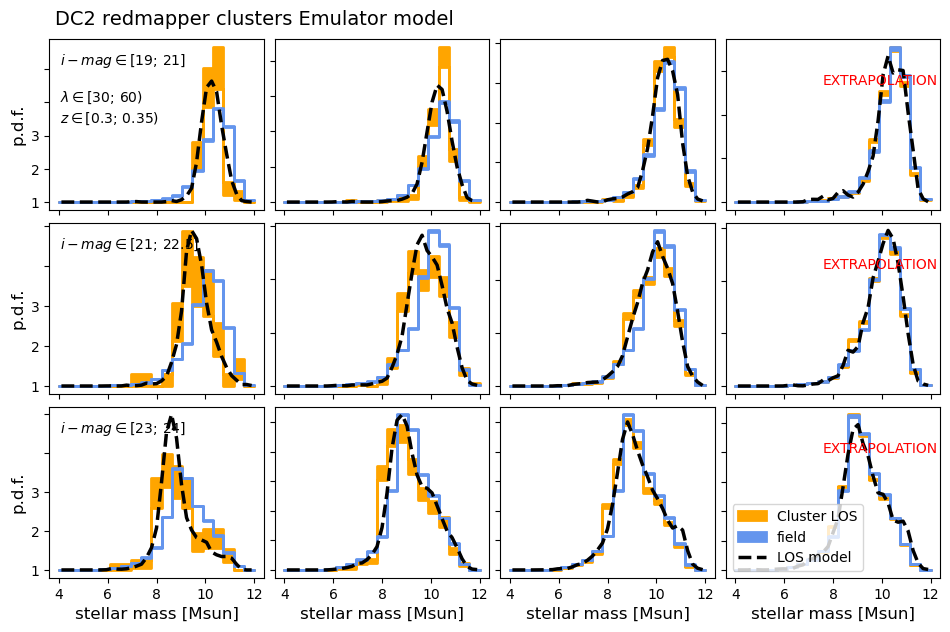

In [17]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(4, 12, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(4, 12, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels(["0", "1", "2", "3", ""])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("stellar mass [Msun]", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "STELLAR_MASS" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    

    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")         
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")    
    
# ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]

    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")        

    
# ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
    
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")     
    handles, labels = ax.get_legend_handles_labels()    

    
fs = 10

axarr[2, 3].legend(loc=3, fontsize=fs, handles=handles, labels=labels)    
# axarr[2, 2].legend(loc=1, fontsize=fs, handles=handles[3:], labels=labels[3:])  
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[0, 3].transAxes, fontsize=fs, color="red")
axarr[1, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[1, 3].transAxes, fontsize=fs, color="red")
axarr[2, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[2, 3].transAxes, fontsize=fs, color="red")
fig.text(0.13, 0.9, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("DC2-ALPHA_LOWZ_decoupled_size_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")


In [12]:
# opath = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01.h5"
# tools.save(opath, csamples)

In [13]:
# ctab = _wide_cr_settings_clust["container"].data
# rtab = _wide_cr_settings_rands["container"].data

# opath = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01_ctab.h5"
# ctab.to_hdf(opath, key="data")
# opath = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01_rtab.h5"
# rtab.to_hdf(opath, key="data")